In [1]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.cluster import AgglomerativeClustering
from pytesseract import Output
from tabulate import tabulate
import pandas as pd
import numpy as np
import pytesseract
import argparse
import imutils
import cv2

In [21]:
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--IMAGE", required=True,help="path to input image to be OCR'd")
ap.add_argument("-o", "--OUTPUT", required=True,help="path to output CSV file")
ap.add_argument("-c", "--MIN_CONF", type=int, default=0,help="minimum confidence value to filter weak text detection")
ap.add_argument("-d", "--DIST_THRESH", type=float, default=25.0,help="distance threshold cutoff for clustering")
ap.add_argument("-s", "--MIN_SIZE", type=int, default=2,help="minimum cluster size (i.e., # of entries in column)")
args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] -i IMAGE -o OUTPUT [-c MIN_CONF] [-d DIST_THRESH] [-s MIN_SIZE]
ipykernel_launcher.py: error: the following arguments are required: -i/--IMAGE, -o/--OUTPUT


SystemExit: 2

In [39]:
# set a seed for our random number generator
np.random.seed(42)
# load the input image and convert it to grayscale
image = cv2.imread('ff.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [40]:
# initialize a rectangular kernel that is ~5x wider than it is tall,
# then smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morphological operator to find dark regions on a light
# background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (51, 11))
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
# compute the Scharr gradient of the blackhat image and scale the
# result into the range [0, 255]
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
# apply a closing operation using the rectangular kernel to close
# gaps in between characters, apply Otsu's thresholding method, and
# finally a dilation operation to enlarge foreground regions
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
thresh = cv2.threshold(grad, 0, 255,
    cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.dilate(thresh, None, iterations=3)

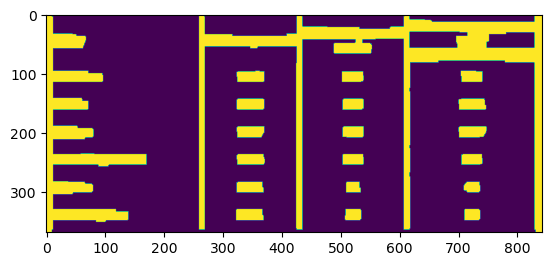

In [41]:
plt.imshow(thresh)

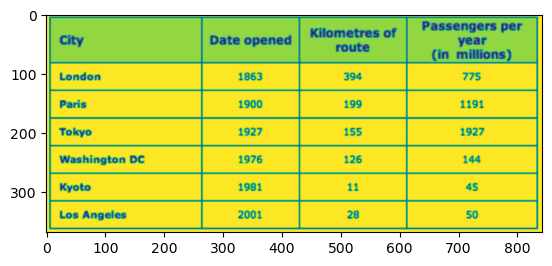

In [42]:
plt.imshow(gray)

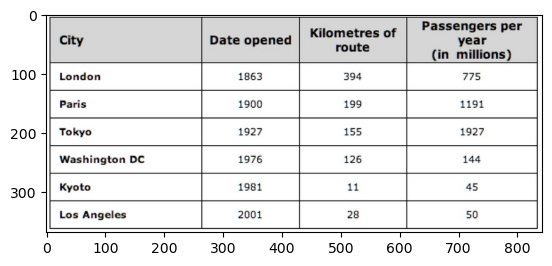

In [43]:
# find contours in the thresholded image and grab the largest one,
# which we will assume is the stats table
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
tableCnt = max(cnts, key=cv2.contourArea)
# compute the bounding box coordinates of the stats table and extract
# the table from the input image
(x, y, w, h) = cv2.boundingRect(tableCnt)
table = image[y:y + h, x:x + w]
# show the original input image and extracted table to our screen
plt.imshow( image)

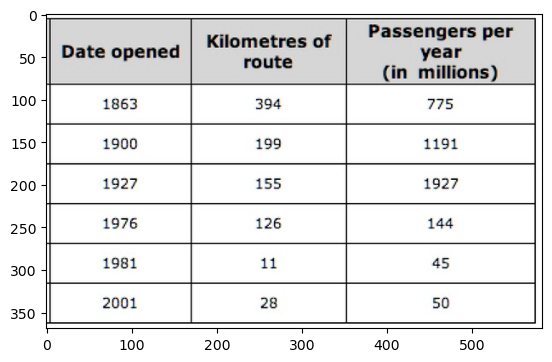

In [44]:
plt.imshow( table)

In [45]:
# set the PSM mode to detect sparse text, and then localize text in
# the table
options = "--psm 6"
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
results = pytesseract.image_to_data(
    cv2.cvtColor(table, cv2.COLOR_BGR2RGB),
    config=options,
    output_type=Output.DICT)
# initialize a list to store the (x, y)-coordinates of the detected
# text along with the OCR'd text itself
coords = []
ocrText = []

In [46]:
# loop over each of the individual text localizations
for i in range(0, len(results["text"])):
    # extract the bounding box coordinates of the text region from
    # the current result
    x = results["left"][i]
    y = results["top"][i]
    w = results["width"][i]
    h = results["height"][i]
    # extract the OCR text itself along with the confidence of the
    # text localization
    text = results["text"][i]
    conf = int(results["conf"][i])
    # filter out weak confidence text localizations
    if conf > 0:
        # update our text bounding box coordinates and OCR'd text,
        # respectively
        coords.append((x, y, w, h))
        ocrText.append(text)

In [47]:
# extract all x-coordinates from the text bounding boxes, setting the
# y-coordinate value to zero
xCoords = [(c[0], 0) for c in coords]
# apply hierarchical agglomerative clustering to the coordinates
clustering = AgglomerativeClustering(
    n_clusters=None,
    affinity="manhattan",
    linkage="complete",
    distance_threshold=25.0)
clustering.fit(xCoords)
# initialize our list of sorted clusters
sortedClusters = []

In [48]:
# loop over all clusters
for l in np.unique(clustering.labels_):
    # extract the indexes for the coordinates belonging to the
    # current cluster
    idxs = np.where(clustering.labels_ == l)[0]
    # verify that the cluster is sufficiently large
    if len(idxs) > 2:
        # compute the average x-coordinate value of the cluster and
        # update our clusters list with the current label and the
        # average x-coordinate
        avg = np.average([coords[i][0] for i in idxs])
        sortedClusters.append((l, avg))
# sort the clusters by their average x-coordinate and initialize our
# data frame
sortedClusters.sort(key=lambda x: x[1])
df = pd.DataFrame()

In [49]:
df

""
